# Amazon SageMaker Object Detection using the Image and JSON format

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes in an image as input and provides a bounding box on the image where an object of interest is, along with identifying what object the box encapsulates. But before we have this solution, we need to acquire and process a training dataset, create and setup a training job for the alorithm so that the aglorithm can learn about the dataset and then host the algorithm as an endpoint, to which we can supply the query image.

In this notebook we will be using a subset of the xView dataset to train out model: http://xviewdataset.org/ To download the full dataset, go to the xView website and create an account. This dataset is licensed under the Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0) [https://creativecommons.org/licenses/by-nc-sa/4.0/] and may only be re-used for noncommercial purposes.

## Setup

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [ ]:
# First we will copy all of the supporting data and utilities for this lab
!aws s3 cp s3://wwps-sagemaker-workshop/xview/utils . --recursive

In [ ]:
!conda install tqdm -y

In [1]:
%%time
import os
import json
import shutil
import logging

from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
        
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

import wv_util as wv
import aug_util as aug

%matplotlib inline

role = get_execution_role()
print(role)

sess = sagemaker.Session()

arn:aws:iam::951232522638:role/service-role/AmazonSageMaker-ExecutionRole-20180312T105280
CPU times: user 2.2 s, sys: 1.58 s, total: 3.78 s
Wall time: 2.05 s


We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. By default we will use the SageMaker bucket that is associated with this session, to use a custom bucket simply change the bucket name. We are using a prefix to keep our default session bucket organized.

In [2]:
bucket = sess.default_bucket()
prefix = 'XView-ObjectDetection'

In [3]:
training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


## Dataset Exploration

Let's see how we can handle the different images and chip them while maintaining the label mapping

In [4]:
coords, chips, classes = wv.get_labels('xview-data/labels/xView_train.geojson')

100%|██████████| 601937/601937 [00:02<00:00, 220067.00it/s]


In [5]:
rlist = {11:"Fixed-wing Aircraft",
         12:"Small Aircraft", 
         13:"Passenger/Cargo Plane",
         15:"Helicopter",
         17:"Passenger Vehicle",
         18:"Small Car",
         19:"Bus",
         20:"Pickup Truck",
         21:"Utility Truck",
         23:"Truck",
         24:"Cargo Truck",
         25:"Truck Tractor w/ Box Trailer",
         26:"Truck Tractor",
         27:"Trailer",
         28:"Truck Tractor w/ Flatbed Trailer",
         29:"Truck Tractor w/ Liquid Tank",
         32:"Crane Truck",
         33:"Railway Vehicle",
         34:"Passenger Car",
         35:"Cargo/Container Car",
         36:"Flat Car",
         37:"Tank car",
         38:"Locomotive",
         40:"Maritime Vessel",
         41:"Motorboat",
         42:"Sailboat",
         44:"Tugboat",
         45:"Barge",
         47:"Fishing Vessel",
         49:"Ferry",
         50:"Yacht",
         51:"Container Ship",
         52:"Oil Tanker",
         53:"Engineering Vehicle",
         54:"Tower crane",
         55:"Container Crane",
         56:"Reach Stacker",
         57:"Straddle Carrier",
         59:"Mobile Crane",
         60:"Dump Truck",
         61:"Haul Truck",
         62:"Scraper/Tractor",
         63:"Front loader/Bulldozer",
         64:"Excavator",
         65:"Cement Mixer",
         66:"Ground Grader",
         71:"Hut/Tent",
         72:"Shed",
         73:"Building",
         74:"Aircraft Hangar",
         75:"Unknown",
         76:"Damaged Building",
         77:"Facility",
         79:"Construction Site",
         82:"Unknown",
         83:"Vehicle Lot",
         84:"Helipad",
         86:"Storage Tank",
         89:"Shipping container lot",
         91:"Shipping Container",
         93:"Pylon",
         94:"Tower"}

In [6]:
test_chip = '104.tif'
test_coords = coords[chips==test_chip]
test_classes = classes[chips==test_chip].astype(np.int64)

#We can find which classes are present in this image
print([rlist[i] for i in np.unique(test_classes)])

['Small Car', 'Bus', 'Truck', 'Cargo Truck', 'Trailer', 'Scraper/Tractor', 'Shed', 'Building', 'Damaged Building']


In [7]:
#We can chip the image into 512x512 chips
c_img, c_box, c_cls = wv.chip_image(img = wv.get_image('./xview-data/train_images/' + test_chip), coords=test_coords, classes=test_classes, shape=(512,512))
print("Num Chips: %d" % c_img.shape[0])


Num Chips: 30


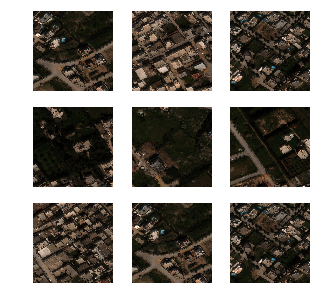

In [8]:
#We can plot some of the chips
fig,ax = plt.subplots(3)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

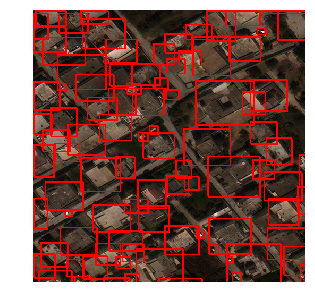

In [9]:
#We can visualize the chips with their labels
ind = np.random.choice(range(c_img.shape[0]))
labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(labelled)

## Data Preparation

Before using this dataset, we need to perform some data cleaning. The algorithm expects the dataset in a particular JSON format. The xView dataset, while containing annotations in JSON, does not follow the built-in algorithm's specifications. So these first several cells are just reformatting the training data to be compatible with Amazon SageMaker's built-in object detection algorithm.

### Prepare dataset 

In the very first step, we convert the provided training images into jpeg images. The Amazon SageMaker Object Detection algorithm only supports .jpg or .png images at this time. To learn more about this algorithm, check out the documentation: https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html

The Amazon SageMaker Object Detection algorithm expects lables to be indexed from `0`. It also expects lables to be unique, successive and not skip any integers. For instance, if there are ten classes, the algorithm expects and the labels only be in the set `[0,1,2,3,4,5,6,7,8,9]`. 

In the xView validation set unfortunately, the labels do not satistify this requirement. Some indices are skipped and the labels start from `1`. We therefore need a mapper that will convert this index system to our requirement. Let us create a generic mapper therefore that could also be used to other datasets that might have nonunique or even string labels. All we need in a dictionary that would create a key-value mapping where an original label is hashed to a label that we require.

In [10]:
# Convert tiff to jpeg images
img_files = []

for infile in os.listdir("./xview-data/train_images"):
    if infile[-3:] == "tif" or infile[-3:] == "bmp" :
        # print "is tif or bmp"
        if not os.path.exists('./xview-data/jpeg_images/'):
            os.mkdir('./xview-data/jpeg_images/')
        outfile = './xview-data/jpeg_images/' + infile[:-3] + "jpeg"
        img_files.append(outfile)
        im = Image.open('./xview-data/train_images/' + infile)
        out = im.convert("RGB")
        out.save(outfile, "JPEG", quality=90)

We will use this dictionary, to create a look up method. Let us do so in a way that any dictionary could be used to create this method, so this code can be re-used for your use-case too!

In [11]:
def get_mapper():
    original_list = [11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33,
                    34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 54,
                    55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 71, 72, 73, 74, 75, 76, 77, 79, 82, 83, 84,
                    86, 89, 91, 93, 94]
    iter_counter = 0
    xView = {}
    for orig in original_list:
        xView[orig] = iter_counter
        iter_counter += 1
    return xView

In [12]:
def get_mapper_fn(map):  
    def mapper(in_category):
        return map[in_category]
    return mapper

fix_index_mapping = get_mapper_fn(get_mapper())

The method `fix_index_mapping` is essentially a look-up method, which we can use to convert lables. Let us now iterate over every annotation in the dataset and prepare our data. Note how the keywords are created and a structure is established. For more information on the JSON format details, refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

This next section generates image chips and then maps them to the labels file provided with the dataset. We use 512x512 sized chips because this image size is optimal for the algorithm.

In [13]:
#Make our Directories
if not os.path.exists('./xview-data/jpeg_chips/'):
    os.mkdir('./xview-data/jpeg_chips/')
if not os.path.exists('./xview-data/generated'):
    os.mkdir('./xview-data/generated')
    
for i in range(len(img_files)):

    arr = wv.get_image(img_files[i])
    match_name = img_files[i][25:-5]+'.tif'
    c_coords = coords[chips==match_name]
    c_classes = classes[chips==match_name].astype(np.int64)
    c_img, c_box, c_cls = wv.chip_image(img = arr, coords= c_coords, classes=c_classes, shape=(512,512))

    for j in range(c_img.shape[0]):
        if(len(c_cls) >= 1 and c_cls[j][0] !=0):
            save_name = img_files[i][25:-5] + "_" + str(j) + '.jpeg'
            chip = Image.fromarray(c_img[j])
            chip.save('./xview-data/jpeg_chips/' + save_name)
    
            jsonFile = save_name
            jsonFile = jsonFile.split('.')[0]+'.json'

            line = {}
            line['file'] = save_name
            line['image_size'] = [{
                'width':512,
                'height':512,
                'depth':3
            }]
    
            line['annotations'] = []
            line['categories'] = []

            for k in range(len(c_box[j])):
                line['annotations'].append({
                    'class_id':int(fix_index_mapping(c_cls[j][k])),
                    'top':int(c_box[j][k][0]),
                    'left':int(c_box[j][k][1]),
                    'width':int(c_box[j][k][2]),
                    'height':int(c_box[j][k][3])
                })
                line['categories'].append({
                    'class_id':int(fix_index_mapping(c_cls[j][k])),
                    'name':rlist.get(c_cls[j][k])
                })
    
            with open(os.path.join('./xview-data/generated', jsonFile),'w') as p:
                json.dump(line,p)

In this next section, we will test the json files and the jpeg image chips we just created to verify that they are still properly mapped to the original data that we tested in the beginning of this notebook.


In [14]:
def visualize_annotation(img_file, dets, classes=[]):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        img=mpimg.imread(img_file)
        plt.figure(figsize=(10,10))
        plt.axis('off')
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            klass = det['class_id']
            x0 = det['top']
            y0 = det['left']
            x1 = det['width']
            y1 = det['height']
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0)
            ymin = int(y0)
            xmax = int(x1)
            ymax = int(y1)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor='red',
                                 linewidth=3.5)
            plt.gca().add_patch(rect)

        plt.show()

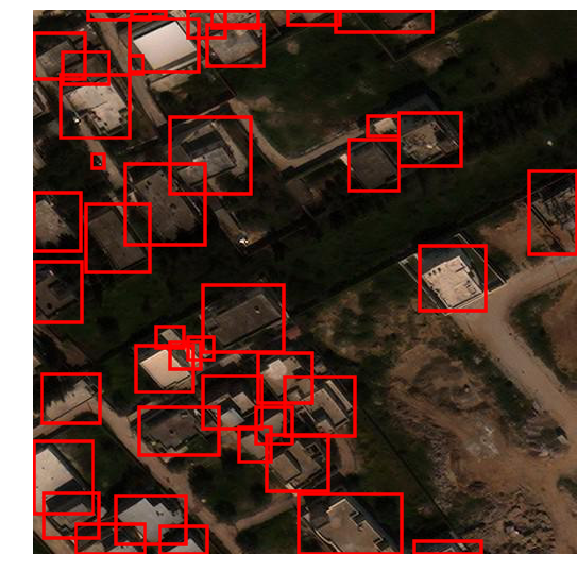

In [45]:
#Test our scripts
img = './xview-data/jpeg_chips/104_1.jpeg'
with open('./xview-data/generated/104_1.json', 'r') as f:
    label = json.load(f)
    
t_img = wv.get_image(img)
t_coords = label['annotations']
t_class = label['categories']

visualize_annotation(img, t_coords, t_class)

In [16]:
jsons = os.listdir('xview-data/generated')

print ('There are {} annotation files'.format(len(jsons)))

There are 987 annotation files


After removing the images without annotations, we have 987 annotated images. Let us split this dataset and create our training and validation datasets, with which our algorithm will train. To do so, we will simply split the dataset into training and validation data and move them to their respective folders.

In [17]:
file_names = []
path = 'xview-data/jpeg_chips'

folder = os.fsencode(path)

for file in os.listdir(folder):
    filename = os.fsdecode(file)
    file_names.append(filename)

In [18]:
#Make our Directories
if not os.path.exists('./xview-data/train/'):
    os.mkdir('./xview-data/train/')
if not os.path.exists('./xview-data/train_annotation'):
    os.mkdir('./xview-data/train_annotation')
if not os.path.exists('./xview-data/validation/'):
    os.mkdir('./xview-data/validation/')
if not os.path.exists('./xview-data/validation_annotation'):
    os.mkdir('./xview-data/validation_annotation')

split = int(len(file_names)*0.8)
train_jsons = file_names[:split]
val_jsons = file_names[split:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = 'xview-data/jpeg_chips/'+i
    shutil.copy(image_file, 'xview-data/train/')
    shutil.copy('xview-data/generated/'+i[:-5]+'.json', 'xview-data/train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = 'xview-data/jpeg_chips/'+i
    shutil.copy(image_file, 'xview-data/validation/')
    shutil.copy('xview-data/generated/'+i[:-5]+'.json', 'xview-data/validation_annotation/')

### Upload to S3
Next step in this process is to upload the data to the S3 bucket, from which the algorithm can read and use the data. We do this using multiple channels. Channels are simply directories in the bucket that differentiate between training and validation data. Let us simply call these directories `train` and `validation`. We will therefore require four channels: two for the data and two for annotations, the annotations ones named with the suffixes `_annotation`.

In [19]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='xview-data/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='xview-data/validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='xview-data/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='xview-data/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 10.3 s, sys: 765 ms, total: 11.1 s
Wall time: 1min 46s


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [20]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [21]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.8xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `30` epochs.

In [22]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=62,
                             mini_batch_size=8,
                             epochs=5,
                             learning_rate=0.001,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=70000,
                             num_training_samples=789)

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes. Notice that here we use a `content_type` as `image/jpeg` for the image channels and the annoation channels. Notice how unlike the [RecordIO format](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb), we use four channels here.

In [23]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following cell will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [24]:
od_model.fit(inputs=data_channels, logs=True)

2019-05-22 17:55:56 Starting - Starting the training job...
2019-05-22 17:55:58 Starting - Launching requested ML instances......
2019-05-22 17:57:07 Starting - Preparing the instances for training.........
2019-05-22 17:58:35 Downloading - Downloading input data...
2019-05-22 17:59:02 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
[05/22/2019 17:59:29 INFO 140597451077440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective_met

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [25]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

----------------------------------------------------------------------------------------------------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. 

In [26]:
file_name = './xview-data/jpeg_chips/104_1.jpeg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [27]:
object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[49.0, 0.18698786199092865, 0.22099339962005615, 0.43155303597450256, 0.9378571510314941, 0.883009672164917], [49.0, 0.18294689059257507, 0.25737056136131287, 0.15817047655582428, 0.9699498414993286, 0.6223250031471252], [49.0, 0.17688427865505219, 0.01662692427635193, 0.29536595940589905, 0.698138952255249, 0.981940507888794], [49.0, 0.17219550907611847, 0.07575136423110962, 0.0, 0.305328369140625, 0.6711314916610718], [49.0, 0.17115899920463562, 0.70252525806427, 0.0, 0.9298291206359863, 0.675064206123352], [49.0, 0.17111654579639435, 0.5783894062042236, 0.0, 0.8024802207946777, 0.6635137796401978], [49.0, 0.16787877678871155, 0.4518983066082001, 0.10090714693069458, 0.6788047552108765, 0.789427638053894], [49.0, 0.16782329976558685, 0.7017418146133423, 0.4851168096065521, 0.9369426965713501, 1.0], [49.0, 0.16240860521793365, 0.19994986057281494, 0.0, 0.42822617292404175, 0.6686632633209229], [49.0, 0.15982702374458313, 0.07453177124261856, 0.3662183880805969, 0.30768

The results are in a format that is similar to the input .lst file (See [RecordIO Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) for more details on the .lst file definition. )with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [54]:
def visualize_detection(img_file, dets, classes=[], thresh=0.5):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor='red',
                                 linewidth=3.5)
            plt.gca().add_patch(rect)

        plt.show()

For the sake of this notebook, we used a small portion of the COCO dataset for training and trained the model with only a few (30) epochs. This implies that the results might not be optimal. To achieve better detection results, you can try to use the more data from COCO dataset and train the model for more epochs. Tuning the hyperparameters, such as `mini_batch_size`, `learning_rate`, and `optimizer`, also helps to get a better detector.

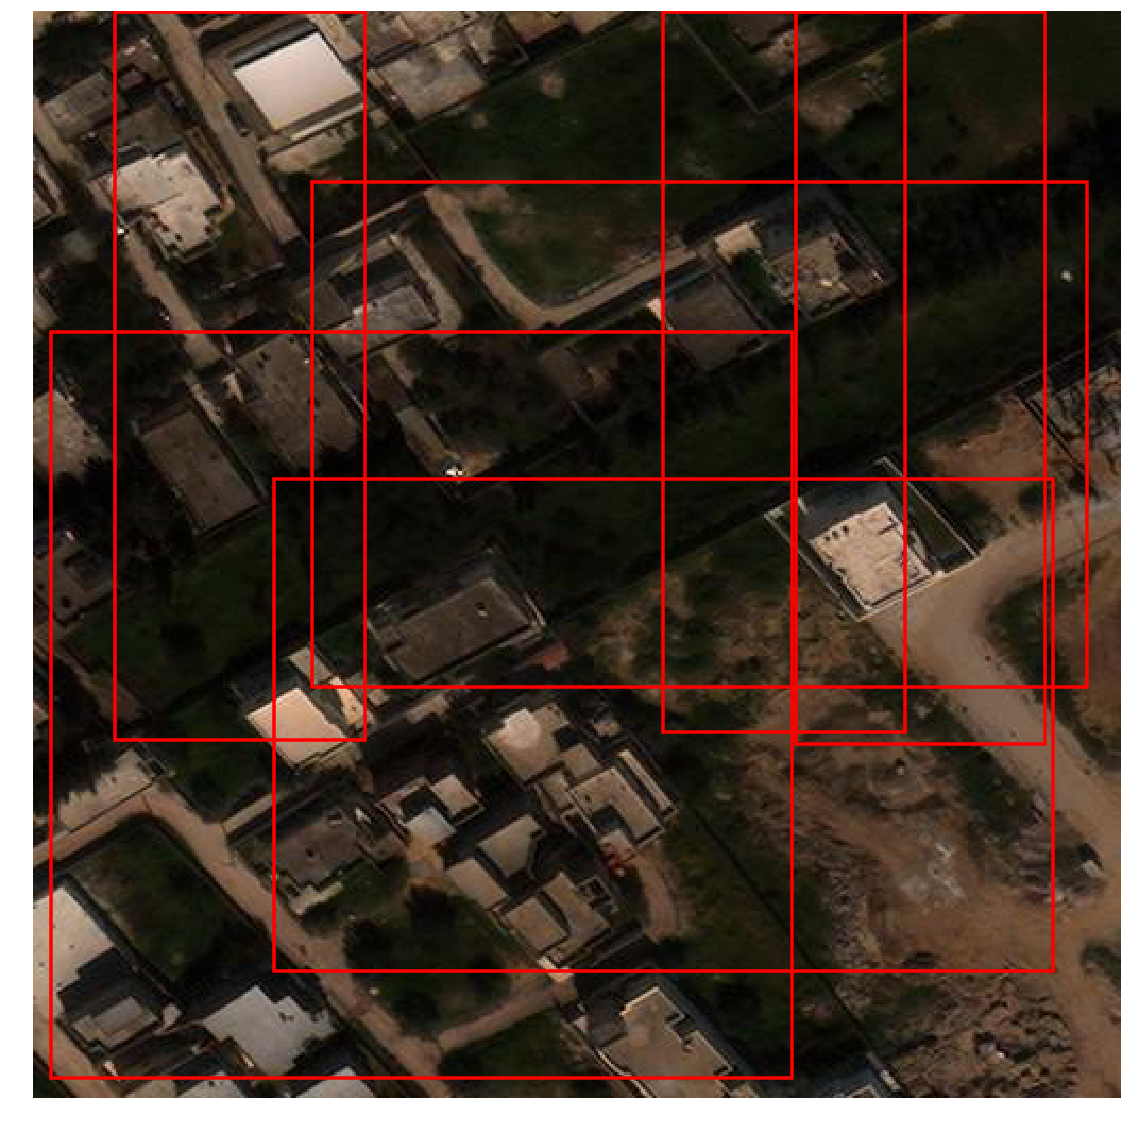

In [59]:
%matplotlib inline

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.17

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], fix_index_mapping, threshold)

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint. To do this, return to the [SageMaker Console](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/dashboard) and click Endpoints. Select the endpoint we created, then click Actions, Delete.